# Mercari NLP

In [73]:
#Standard imports
import pandas as pd
import os
import sys
import string
import re
import numpy as np

#Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#SKlearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#NLTK
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk import WordNetLemmatizer # lemmatizer using WordNet
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag # nltk's native part of speech tagging

In [74]:
import pyLDAvis.sklearn # a specialized package for topic model visualization

In [75]:
#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

## Preproccessing

In [76]:
train_df = pd.read_csv("/Users/javm/Desktop/Mercari-Price-Prediction-Project/vader_data")

In [77]:
train_df

,train_id,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compund_sentiment_desc
0,1392338,Size small Gianni Bini Dress,2,"Women Dresses Above Knee, Mini",14.0,0,Beautiful dress from Dilliards. Size small. La...,0,0.6988
1,1125521,36B Victoria's Secret & Aerie Bra Set,3,Women Underwear Bras,41.0,0,Wireless. Good Used Condition. Smoke free home...,1,0.7351
2,662640,Victoria's Secret Leggings,2,"Women Athletic Apparel Pants, Tights, Leggings",24.0,0,From a smoke free home Size small,1,0.5106
3,195122,Morphe 35P palette w/FREE GIFTS!!,3,Beauty Makeup Makeup Palettes,19.0,0,"Unused, but one shadow broken. A little bit of...",1,0.9750
4,1319269,Monster high doll for ashley,3,Kids Toys Dolls & Accessories,11.0,1,Duece,0,0.0000
...,...,...,...,...,...,...,...,...,...
99995,51125,iPhone 7 Plus Otter Box Defender,2,"Electronics Cell Phones & Accessories Cases, C...",26.0,0,Barely used still like new,1,0.3041
99996,11925,Lularoe Azure XL,3,Women Dresses Knee-Length,16.0,1,Violet azure with white polka dots. Fits like ...,1,0.4753
99997,875729,7 Bundle Wii + GameCube Games,3,Electronics Video Games & Consoles Games,22.0,1,Total of 7 games - rec room - Mario sports mix...,1,0.7351
99998,1250401,Huda beauty,1,Beauty Makeup Makeup Palettes,21.0,0,Brand new never used,1,0.0000


In [78]:
train_df['category_name'].value_counts()

Women Athletic Apparel Pants, Tights, Leggings    6393
Women Tops & Blouses T-Shirts                     4580
Beauty Makeup Face                                3723
Beauty Makeup Lips                                3133
Beauty Makeup Eyes                                2663
                                                  ... 
Beauty Bath & Body Bath                            525
Kids Boys 0-24 Mos One-Pieces                      525
Men Shoes Fashion Sneakers                         517
Women Shoes Flats                                  516
Home Kitchen & Dining Dining & Entertaining        501
Name: category_name, Length: 76, dtype: int64

In [79]:
def process_text(clean_text, min_length):
    
    stop_words = stopwords.words('english')
    wnl = WordNetLemmatizer()
    
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    clean_lower = clean_text.lower()

#     #remove mentions, hashtags, and urls, strip whitspace and breaks
#     tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(clean_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return text_norm


In [80]:
train_df['category_topic'] = train_df['category_name'].apply(process_text, args = [1])

In [81]:
train_df_new = train_df[train_df['category_topic'] != '']

In [83]:
train_df_new

,train_id,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compund_sentiment_desc,category_topic
0,1392338,Size small Gianni Bini Dress,2,"Women Dresses Above Knee, Mini",14.0,0,Beautiful dress from Dilliards. Size small. La...,0,0.6988,woman dress knee mini
1,1125521,36B Victoria's Secret & Aerie Bra Set,3,Women Underwear Bras,41.0,0,Wireless. Good Used Condition. Smoke free home...,1,0.7351,woman underwear bra
2,662640,Victoria's Secret Leggings,2,"Women Athletic Apparel Pants, Tights, Leggings",24.0,0,From a smoke free home Size small,1,0.5106,woman athletic apparel pant tights legging
3,195122,Morphe 35P palette w/FREE GIFTS!!,3,Beauty Makeup Makeup Palettes,19.0,0,"Unused, but one shadow broken. A little bit of...",1,0.9750,beauty makeup makeup palette
4,1319269,Monster high doll for ashley,3,Kids Toys Dolls & Accessories,11.0,1,Duece,0,0.0000,kid toy doll accessory
...,...,...,...,...,...,...,...,...,...,...
99995,51125,iPhone 7 Plus Otter Box Defender,2,"Electronics Cell Phones & Accessories Cases, C...",26.0,0,Barely used still like new,1,0.3041,electronics cell phone accessory case cover skin
99996,11925,Lularoe Azure XL,3,Women Dresses Knee-Length,16.0,1,Violet azure with white polka dots. Fits like ...,1,0.4753,woman dress
99997,875729,7 Bundle Wii + GameCube Games,3,Electronics Video Games & Consoles Games,22.0,1,Total of 7 games - rec room - Mario sports mix...,1,0.7351,electronics video game console game
99998,1250401,Huda beauty,1,Beauty Makeup Makeup Palettes,21.0,0,Brand new never used,1,0.0000,beauty makeup makeup palette


In [84]:
tf_vec = TfidfVectorizer()
category_transformed = tf_vec.fit_transform(train_df_new['category_topic'])
category_transformed

<98487x114 sparse matrix of type '<class 'numpy.float64'>'
	with 364174 stored elements in Compressed Sparse Row format>

In [85]:
len(tf_vec.get_feature_names())

114

In [86]:
from sklearn.decomposition import NMF

In [87]:
topic_model = NMF(n_components = 5)
topic_model.fit(category_transformed)

NMF(n_components=5)

In [88]:
# to get H
H = topic_model.transform(category_transformed) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(category_transformed.shape))

Shape of W is (5, 114)
Shape of H is (98487, 5)
Shape of X_train is (98487, 114)


In [89]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tf_vec.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['craft', 'crewneck', 'crossbody', 'cut', 'daily', 'dress', 'tot', 'din', 'shoe', 'men', 'jean', 'top', 'bra', 'tracksuits', 'sweat', 'sport', 'jacket', 'shirt', 'short', 'woman', 'pant', 'tights', 'legging', 'apparel', 'athletic']


THE TOP 10 WORDS FOR TOPIC #1
['earring', 'entertain', 'electronics', 'décor', 'home', 'daily', 'item', 'personal', 'travel', 'bath', 'brush', 'woman', 'tool', 'body', 'set', 'nail', 'skin', 'fragrance', 'care', 'palette', 'eye', 'lip', 'face', 'beauty', 'makeup']


THE TOP 10 WORDS FOR TOPIC #2
['messenger', 'tot', 'shopper', 'handbags', 'sunglass', 'shoulder', 'bag', 'hat', 'sweater', 'athletic', 'swimwear', 'handbag', 'fragrance', 'wallet', 'accessory', 'apparel', 'blouses', 'tunic', 'shirt', 'men', 'tank', 'cami', 'woman', 'top', 'blouse']


THE TOP 10 WORDS FOR TOPIC #3
['sweater', 'pump', 'earring', 'wallet', 'boys', 'handbag', 'fragrance', 'accessory', 'bracelet', 'sneaker', 'fashion', 'mini', 'knee', 'kid', 'bra', 'men

In [90]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = tf_vec.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

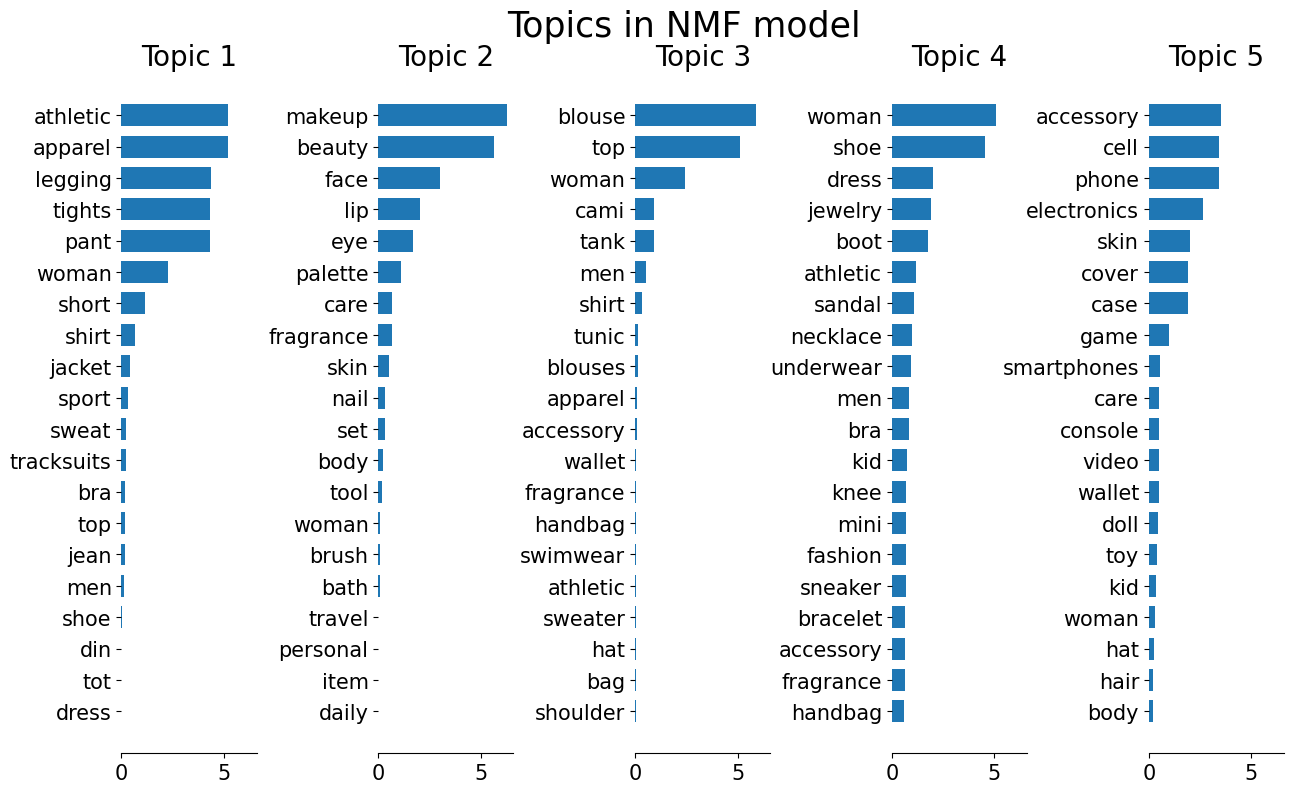

In [91]:
topic_word_plot()

In [92]:
topic_name_dict = {0: 'clothing', 1: 'beauty products', 2: "women's clothing", 3: 'accessories', 4: 'electronics'}

In [93]:
tsne = TSNE(learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

In [94]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

ImportError: cannot import name 'find_stack_level' from 'pandas.util._exceptions' (/Users/javm/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/util/_exceptions.py)

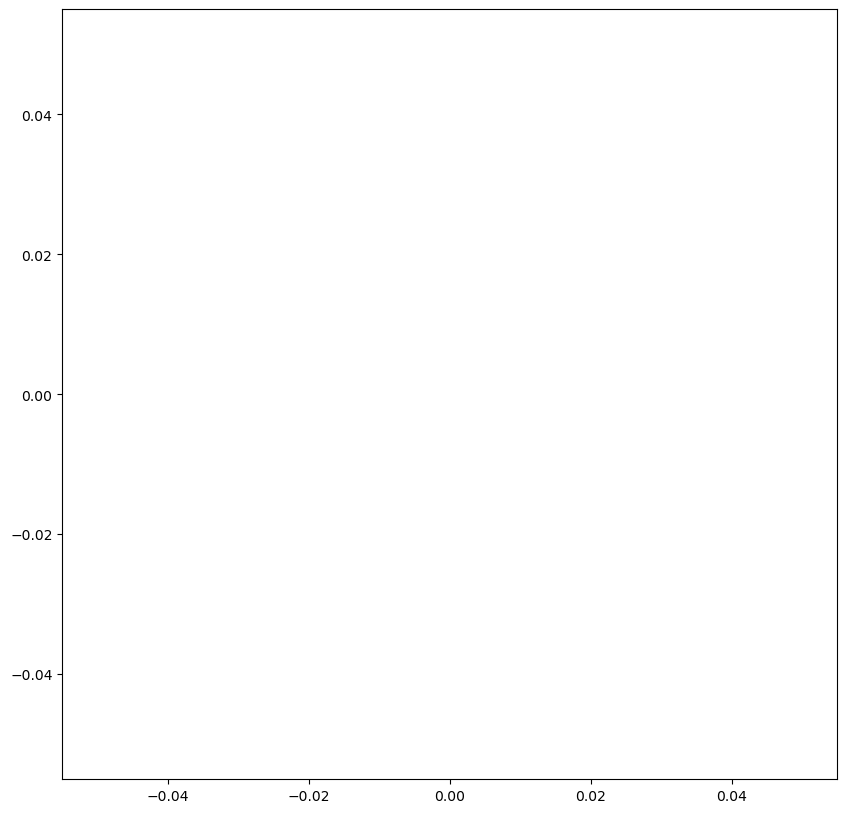

In [95]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Category Sections')
plt.show()

In [96]:
H_repres_norm = pd.DataFrame(H, columns = topic_name_dict.values(), index = train_df.index)
H_repres_norm = H_repres_norm.divide(H_repres_norm.sum(axis=1), axis=0)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/javm/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/managers.py", line 1665, in create_block_manager_from_blocks
  File "/Users/javm/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/managers.py", line 149, in __init__
  File "/Users/javm/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/internals/managers.py", line 326, in _verify_integrity
ValueError: Shape of passed values is (98487, 5), indices imply (100000, 5)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/javm/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/6g/zn0bw_6s1ws2qwbb44k4ppkw0000gn/T/ipykernel_28832/520649756.py", line 1, in <module>
    H_repres_norm = pd.DataFrame(H, columns = to

In [97]:
H_repres_norm.head()

,clothing,beauty products,women's clothing,accessories,electronics
0,0.000000,0.000000,0.000000,0.039967,0.000000
1,0.000255,0.000000,0.001837,0.034277,0.000000
2,0.089750,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.078874,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.007231,0.034118


In [99]:
topic_df = train_df.join(H_repres_norm)
topic_df

,train_id,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compund_sentiment_desc,category_topic,clothing,beauty products,women's clothing,accessories,electronics
0,1392338,Size small Gianni Bini Dress,2,"Women Dresses Above Knee, Mini",14.0,0,Beautiful dress from Dilliards. Size small. La...,0,0.6988,woman dress knee mini,0.000000,0.000000,0.000000,0.039967,0.000000
1,1125521,36B Victoria's Secret & Aerie Bra Set,3,Women Underwear Bras,41.0,0,Wireless. Good Used Condition. Smoke free home...,1,0.7351,woman underwear bra,0.000255,0.000000,0.001837,0.034277,0.000000
2,662640,Victoria's Secret Leggings,2,"Women Athletic Apparel Pants, Tights, Leggings",24.0,0,From a smoke free home Size small,1,0.5106,woman athletic apparel pant tights legging,0.089750,0.000000,0.000000,0.000000,0.000000
3,195122,Morphe 35P palette w/FREE GIFTS!!,3,Beauty Makeup Makeup Palettes,19.0,0,"Unused, but one shadow broken. A little bit of...",1,0.9750,beauty makeup makeup palette,0.000000,0.078874,0.000000,0.000000,0.000000
4,1319269,Monster high doll for ashley,3,Kids Toys Dolls & Accessories,11.0,1,Duece,0,0.0000,kid toy doll accessory,0.000000,0.000000,0.000000,0.007231,0.034118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,51125,iPhone 7 Plus Otter Box Defender,2,"Electronics Cell Phones & Accessories Cases, C...",26.0,0,Barely used still like new,1,0.3041,electronics cell phone accessory case cover skin,0.000000,0.000000,0.000000,0.000000,0.120283
99996,11925,Lularoe Azure XL,3,Women Dresses Knee-Length,16.0,1,Violet azure with white polka dots. Fits like ...,1,0.4753,woman dress,0.000000,0.000000,0.002292,0.051751,0.000000
99997,875729,7 Bundle Wii + GameCube Games,3,Electronics Video Games & Consoles Games,22.0,1,Total of 7 games - rec room - Mario sports mix...,1,0.7351,electronics video game console game,0.000000,0.000000,0.000000,0.000000,0.033468
99998,1250401,Huda beauty,1,Beauty Makeup Makeup Palettes,21.0,0,Brand new never used,1,0.0000,beauty makeup makeup palette,0.000000,0.078874,0.000000,0.000000,0.000000


In [100]:
topic_df = topic_df.drop(columns = 'category_topic', axis = 1)

In [101]:
topic_df

,train_id,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compund_sentiment_desc,clothing,beauty products,women's clothing,accessories,electronics
0,1392338,Size small Gianni Bini Dress,2,"Women Dresses Above Knee, Mini",14.0,0,Beautiful dress from Dilliards. Size small. La...,0,0.6988,0.000000,0.000000,0.000000,0.039967,0.000000
1,1125521,36B Victoria's Secret & Aerie Bra Set,3,Women Underwear Bras,41.0,0,Wireless. Good Used Condition. Smoke free home...,1,0.7351,0.000255,0.000000,0.001837,0.034277,0.000000
2,662640,Victoria's Secret Leggings,2,"Women Athletic Apparel Pants, Tights, Leggings",24.0,0,From a smoke free home Size small,1,0.5106,0.089750,0.000000,0.000000,0.000000,0.000000
3,195122,Morphe 35P palette w/FREE GIFTS!!,3,Beauty Makeup Makeup Palettes,19.0,0,"Unused, but one shadow broken. A little bit of...",1,0.9750,0.000000,0.078874,0.000000,0.000000,0.000000
4,1319269,Monster high doll for ashley,3,Kids Toys Dolls & Accessories,11.0,1,Duece,0,0.0000,0.000000,0.000000,0.000000,0.007231,0.034118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,51125,iPhone 7 Plus Otter Box Defender,2,"Electronics Cell Phones & Accessories Cases, C...",26.0,0,Barely used still like new,1,0.3041,0.000000,0.000000,0.000000,0.000000,0.120283
99996,11925,Lularoe Azure XL,3,Women Dresses Knee-Length,16.0,1,Violet azure with white polka dots. Fits like ...,1,0.4753,0.000000,0.000000,0.002292,0.051751,0.000000
99997,875729,7 Bundle Wii + GameCube Games,3,Electronics Video Games & Consoles Games,22.0,1,Total of 7 games - rec room - Mario sports mix...,1,0.7351,0.000000,0.000000,0.000000,0.000000,0.033468
99998,1250401,Huda beauty,1,Beauty Makeup Makeup Palettes,21.0,0,Brand new never used,1,0.0000,0.000000,0.078874,0.000000,0.000000,0.000000


In [105]:
topic_df.to_csv('topic',index = False)

In [ ]:
# 1. vader_df.to_csv('vad',index=False)
# 2. topic_df.to_csv('topic',index = False)